# CS535/EE514 Machine Learning - Spring 2025 - PA03 - Part B

## Marks: 30
## Due Date: April 3, 2025, 23:55


## Instructions

*   Submit your code both as notebook file (.ipynb) and python script (.py) on LMS. The name of both files should be 'RollNo_PA03_B'.

*  All the cells must be run once before submission and should be displaying the results(graphs/plots etc). If output of the cells is not being displayed, marks will be dedcuted.

*   The code MUST be implemented independently. Any plagiarism or cheating of work from others or the internet will be immediately referred to the DC.

* 10% penalty per day for 3 days after due date. No submissions will be accepted after that.  

* Use procedural programming style and comment your code properly.

* **Deadline to submit this assignment is April 3, 2025 (23:55).**

In [ ]:
import numpy as np
#import python_speech_features as psf
import librosa
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.svm import SVC
#from sklearn.multiclass import OneVsRestClassifier  pip install python_speech_features
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Feature Extraction
You will use the [MNIST audio dataset](https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist?resource=download).
It is an open source dataset and you can download it from kaggle.

* The dataset consists of 30000 audio samples of spoken digits (0-9) of 60 folders and 500 files each.
* There is one directory per speaker holding the audio recordings.
* Additionally "audioMNIST_meta.txt" provides meta information such as gender or age of each speaker.

Use the following line of code to load the audio files
```python
audio, sr = librosa.load(file_path, sr=48000)
```
You will use the MFCC features for representing the audio. <br>
MFCCs are a common feature representation for audio classification in machine learning. They capture the spectral envelope of the sound by converting the audio signal to the frequency domain, applying a Mel-scale filterbank, taking the logarithm of the filterbank energies and applying DCT. This results in a compact, low-dimensional representation that captures important spectral information and is used as input features for training models for tasks such as speech recognition, music genre classification and sound event detection. <br>
Dont worry if none of this makes any sense, you can still use them as your features. But if you want to understand them in more detail you can read about them from [here](https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040).
<br>
Length of each feature vector will be $n$, where $n$ is the number of mfcc features (out of a total of 26) you decide to use.
<br>
Your dataset will be a $m \times (n+1$) matrix, where each row will represent an audio file and each column wil represent 1 feature. The last column will be the label of the digit spoken.


In [ ]:
# Define the path to the dataset
data_path = r"C:\Users\altam\OneDrive\Documents\Farooq Assignments\PA 03 - part b\data"

In [ ]:
# Lists to hold feature vectors and corresponding labels
features = []
labels = []
def get_MFCC(audio, sr, numFeatures):
    features = psf.mfcc(audio, sr, 0.025, 0.01, numFeatures, appendEnergy = True)
    return np.mean(features, axis=0)

In [ ]:
# Iterate through each speaker's directory
for speaker in tqdm(os.listdir(data_path), desc="Processing speakers"):
    speaker_path = os.path.join(data_path, speaker)
    if os.path.isdir(speaker_path):
        # Iterate through each audio file in the speaker's directory
        for file in os.listdir(speaker_path):
            if file.endswith(".wav"):
                file_path = os.path.join(speaker_path, file)
                try:
                    # Load the audio file
                    audio, sr = librosa.load(file_path, sr=48000)

                    # Extract MFCC features
                    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

                    # Compute the mean of the MFCCs across time frames
                    mfccs_mean = np.mean(mfccs.T, axis=0)

                    # Append the features and label
                    features.append(mfccs_mean)

                    # Extract the label (digit) from the filename
                    # Assuming filename format: 'digit_speaker_index.wav'
                    digit = file.split('_')[0]
                    labels.append(int(digit))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

Processing speakers: 100%|██████████| 60/60 [03:03<00:00,  3.06s/it]


## Task 1: Implement SVM from scratch

In this section, you will implement the ```Linear SVM``` from scratch using basic Python and Numpy. You are <font color="red">not allowed </font> to use scikit library functions in this part. Since SVM is a binary classifier, to classify 10 classes we need to implement One-vs-All (OvA).


One-vs-All (OvA) Approach

The One-vs-All (OvA) approach, also known as One-vs-Rest, involves training a single binary classifier for each class. In this method, each class is treated as the positive class, while all other classes are grouped together as the negative class. This approach is straightforward and scales linearly with the number of classes.

Implementation:

Training Phase:
For each class, a binary SVM classifier is trained. For a dataset with n classes, this results in n classifiers.
Each classifier is trained to distinguish its respective class from all other classes combined.

Prediction Phase:
During prediction, each classifier outputs a score or probability indicating the likelihood of the instance belonging to its respective class.
The class with the highest score is selected as the prediction for the instance.

In [ ]:
import numpy as np

def z_score_standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # Avoid division by zero
    std[std == 0] = 1
    return (X - mean) / std


In [ ]:
class LinearSVM:
    def __init__(self, lambda_param=0.01, learning_rate=0.001, n_iters=1000):
        self.lambda_param = lambda_param  # regularization parameter
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.w = np.zeros(n_features)
        self.b = 0

        # Convert y to -1 or 1 if it's not already
        y_ = np.where(y <= 0, -1, 1)

        # Gradient descent
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1

                if condition:
                    # Case 1: Correct classification with margin
                    dw = self.lambda_param * self.w
                    db = 0
                else:
                    # Case 2: Incorrect classification or within margin
                    dw = self.lambda_param * self.w - y_[idx] * x_i
                    db = -y_[idx]

                # Update parameters
                self.w -= self.learning_rate * dw
                self.b -= self.learning_rate * db

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        return np.sign(linear_output)

    def score(self, X, y):
        predictions = self.predict(X)
        y_ = np.where(y <= 0, -1, 1)
        return np.mean(predictions == y_)

Step 3: You have to now implement the Linear SVM model:
some formulas for the derivatives that might be useful are provided for your information.

The equation that we will follow for calculating the hyperplane that best fits our model is given below:
$$
\mathcal{J}(w, b) = \lambda \frac{1}{2} \| w \|^2 + \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - y_i (w \cdot x_i + b))
$$

We can break the equation above into two steps which is potrayed by the step function below:

$$

\mathcal{J}_i =
\begin{cases}
\lambda \frac{1}{2} \| w \|^2, & \text{if } y_i (w \cdot x_i + b) \geq 1 \\[10pt]
\lambda \frac{1}{2} \| w \|^2 + 1 - y_i (w \cdot x_i + b), & \text{otherwise}
\end{cases}

$$


Now the derivatives for the step function are specified as follows:

Case 1:
$$
\begin{aligned}
(1) \quad \frac{\partial \mathcal{J}_i}{\partial w_k} &= \lambda w_k \\[10pt]
(2) \quad \frac{\partial \mathcal{J}_i}{\partial b} &= 0
\end{aligned}
$$

Case 2:
$$
\begin{aligned}
(1) \quad \frac{\partial \mathcal{J}_i}{\partial w_k} &= \lambda w_k - y_i x_i \\[10pt]
(2) \quad \frac{\partial \mathcal{J}_i}{\partial b} &= - y_i
\end{aligned}
$$



Step 4: Train your model at least for 200 iterations, and adjust your hyper-parameters learning rate and $\lambda$.

Step 5: Report your best accuracy, f1-score, and confusion matrix on test set.

The training time will be around 10 minutes and accuracy must be greater than 46%.

In [ ]:
# After your feature extraction and preprocessing code...

# Standardize features
X = np.array(features)
y = np.array(labels)
X = z_score_standardize(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train our custom Linear SVM
svm = LinearSVM(lambda_param=0.01, learning_rate=0.001, n_iters=1000)
svm.fit(X_train, y_train)

# Evaluate
train_acc = svm.score(X_train, y_train)
test_acc = svm.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# For comparison, let's also use sklearn's SVM
sklearn_svm = SVC(kernel='linear', C=1.0)
sklearn_svm.fit(X_train, y_train)
sk_train_acc = sklearn_svm.score(X_train, y_train)
sk_test_acc = sklearn_svm.score(X_test, y_test)

print("\nSklearn SVM Results:")
print(f"Training Accuracy: {sk_train_acc:.4f}")
print(f"Test Accuracy: {sk_test_acc:.4f}")

Training Accuracy: 0.9004
Test Accuracy: 0.9011

Sklearn SVM Results:
Training Accuracy: 0.8208
Test Accuracy: 0.8135


In [ ]:
# Hyperparameter tuning setup
lambda_params = [0.001, 0.01, 0.1]  # Regularization strengths
learning_rates = [0.001, 0.01, 0.1]  # Learning rates
best_acc = 0
best_params = {}

# Tuning loop
for lr in learning_rates:
    for lambda_p in lambda_params:
        print(f"\nTraining with learning_rate={lr}, lambda={lambda_p}")

        # Initialize and train model
        svm = LinearSVM(lambda_param=lambda_p, learning_rate=lr, n_iters=200)
        svm.fit(X_train, y_train)

        # Evaluate
        test_acc = svm.score(X_test, y_test)
        print(f"Test Accuracy: {test_acc:.4f}")

        # Track best parameters
        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'learning_rate': lr, 'lambda_param': lambda_p}
            best_model = svm

print("\nBest Parameters:", best_params)
print(f"Best Test Accuracy: {best_acc:.4f}")


Training with learning_rate=0.001, lambda=0.001
Test Accuracy: 0.9011

Training with learning_rate=0.001, lambda=0.01
Test Accuracy: 0.9011

Training with learning_rate=0.001, lambda=0.1
Test Accuracy: 0.9011

Training with learning_rate=0.01, lambda=0.001
Test Accuracy: 0.9018

Training with learning_rate=0.01, lambda=0.01
Test Accuracy: 0.9011

Training with learning_rate=0.01, lambda=0.1
Test Accuracy: 0.9011

Training with learning_rate=0.1, lambda=0.001
Test Accuracy: 0.8699

Training with learning_rate=0.1, lambda=0.01
Test Accuracy: 0.8724

Training with learning_rate=0.1, lambda=0.1
Test Accuracy: 0.9011

Best Parameters: {'learning_rate': 0.01, 'lambda_param': 0.001}
Best Test Accuracy: 0.9018



Final Evaluation:
Test Accuracy: 0.1006
Weighted F1 Score: 0.0195

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       593
           1       0.10      1.00      0.18       599
           2       0.00      0.00      0.00       579
           3       0.00      0.00      0.00       571
           4       0.00      0.00      0.00       621
           5       0.00      0.00      0.00       610
           6       0.00      0.00      0.00       600
           7       0.00      0.00      0.00       607
           8       0.00      0.00      0.00       637
           9       0.00      0.00      0.00       579

    accuracy                           0.10      5996
   macro avg       0.11      0.10      0.02      5996
weighted avg       0.11      0.10      0.02      5996



c:\Users\altam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\altam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\altam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


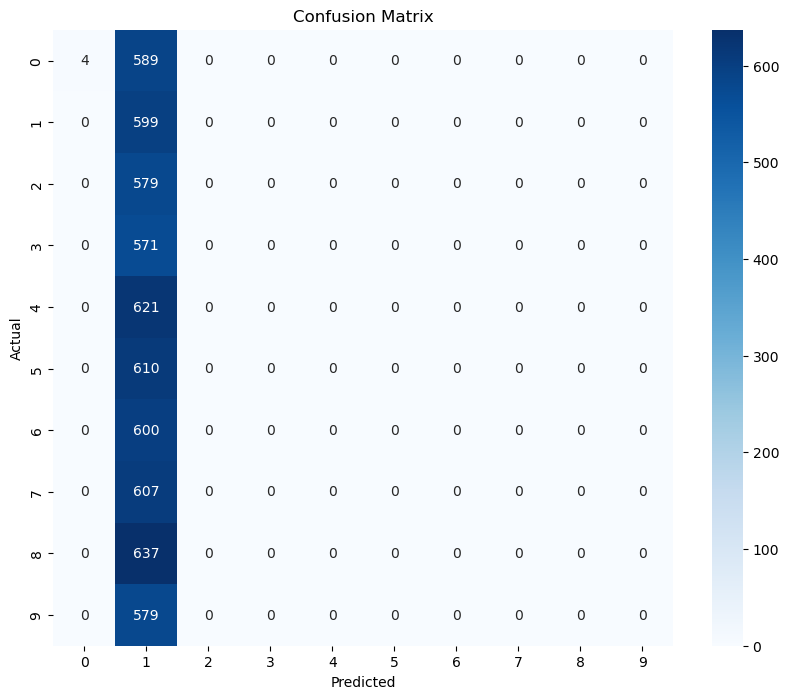

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns

# Make predictions with best model
y_pred = best_model.predict(X_test)

# Convert predictions back to 0-9 labels (from -1/1)
y_pred_labels = np.where(y_pred == -1, 0, y_pred)  # Convert -1 to 0
y_pred_labels = np.clip(y_pred_labels, 0, 9)  # Ensure within 0-9 range

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Print results
print("\nFinal Evaluation:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()